# 🏢 Projet IA - Prédiction d'Attrition chez HumanForYou

## Contexte de l'entreprise

**HumanForYou** est une entreprise pharmaceutique basée en Inde employant environ **4000 personnes**. 
Elle fait face à un taux de rotation annuel de **~15%**, ce qui engendre :

| Problème | Impact |
|----------|--------|
| Retards projets | Réputation client dégradée |
| Coûts RH élevés | Recrutement et formation |
| Perte de productivité | Temps d'adaptation des nouveaux |

## Objectif du projet

Développer un **modèle de Machine Learning** capable de :
1. **Identifier** les facteurs influençant le départ des employés
2. **Prédire** quels employés sont à risque de quitter l'entreprise
3. **Proposer** des actions RH pour améliorer la rétention

## Données disponibles

| Fichier | Description | Variables clés |
|---------|-------------|----------------|
| `general_data.csv` | Données RH générales | Age, Salaire, Ancienneté... |
| `manager_survey_data.csv` | Évaluation manager | Performance, Implication |
| `employee_survey_data.csv` | Enquête satisfaction | Environnement, Équilibre vie |
| `in_time.csv` / `out_time.csv` | Horaires badgeuse | Heures travail, Retards |

---

## 1. Importation des librairies

Dans cette étape, nous importons toutes les librairies nécessaires pour :
- Manipuler les données (pandas, numpy)
- Faire des visualisations (matplotlib, seaborn)
- Préparer et entraîner les modèles de Machine Learning (scikit-learn)

In [77]:
# =========================================================
# 1. Importation des librairies
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Modèles ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE

# Export modèle
import joblib

# Style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Librairies importées avec succès!")

✅ Librairies importées avec succès!


---
## 2. Chargement des données

Nous chargeons ici les différents fichiers CSV fournis :
- **general_data** : informations RH générales
- **manager_survey_data** : évaluations des managers
- **employee_survey_data** : satisfaction des employés

L'objectif est d'assembler l'ensemble des informations relatives à chaque employé.

In [78]:
# =========================================================
# 2. Chargement des données
# =========================================================

# Lecture des fichiers
general = pd.read_csv("data/general_data(1).csv")
manager = pd.read_csv("data/manager_survey_data.csv")
employee = pd.read_csv("data/employee_survey_data.csv")

print(f"📊 general_data: {general.shape[0]} lignes, {general.shape[1]} colonnes")
print(f"📊 manager_survey: {manager.shape[0]} lignes, {manager.shape[1]} colonnes")
print(f"📊 employee_survey: {employee.shape[0]} lignes, {employee.shape[1]} colonnes")

📊 general_data: 4410 lignes, 24 colonnes
📊 manager_survey: 4410 lignes, 3 colonnes
📊 employee_survey: 4410 lignes, 4 colonnes


In [79]:
# Fusion des datasets sur EmployeeID
df = general.merge(manager, on="EmployeeID", how="left")
df = df.merge(employee, on="EmployeeID", how="left")

print(f"✅ Dataset fusionné: {df.shape[0]} lignes, {df.shape[1]} colonnes")
df.head()

✅ Dataset fusionné: 4410 lignes, 29 colonnes


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


---
## 3. Exploration initiale des données

Avant de nettoyer les données, examinons leur structure, les types de variables et les valeurs manquantes.

In [80]:
# Structure du dataset
print("📋 Structure du dataset:")
print("=" * 50)
df.info()

📋 Structure du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  

In [81]:
# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Valeurs manquantes': missing, 'Pourcentage (%)': missing_pct})
missing_df = missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Valeurs manquantes', ascending=False)

print("\n🔍 Colonnes avec valeurs manquantes:")
print("=" * 50)
print(missing_df)


🔍 Colonnes avec valeurs manquantes:
                         Valeurs manquantes  Pourcentage (%)
WorkLifeBalance                          38             0.86
EnvironmentSatisfaction                  25             0.57
JobSatisfaction                          20             0.45
NumCompaniesWorked                       19             0.43
TotalWorkingYears                         9             0.20


---
## 4. Traitement des valeurs manquantes

Stratégie de traitement :
- **Variables numériques** (NumCompaniesWorked, TotalWorkingYears) → Imputation par la **médiane**
- **Variables catégorielles/ordinales** (EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance) → Imputation par le **mode**

In [82]:
# =========================================================
# 4. Traitement des valeurs manquantes
# =========================================================

# Variables numériques → Médiane
numerical_cols = ['NumCompaniesWorked', 'TotalWorkingYears']
for col in numerical_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"✅ {col}: imputé par médiane = {median_val}")

# Variables ordinales → Mode
ordinal_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for col in ordinal_cols:
    if col in df.columns:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"✅ {col}: imputé par mode = {mode_val}")

# Vérification
print(f"\n🔍 Valeurs manquantes restantes: {df.isnull().sum().sum()}")

✅ NumCompaniesWorked: imputé par médiane = 2.0
✅ TotalWorkingYears: imputé par médiane = 10.0
✅ EnvironmentSatisfaction: imputé par mode = 3.0
✅ JobSatisfaction: imputé par mode = 4.0
✅ WorkLifeBalance: imputé par mode = 3.0

🔍 Valeurs manquantes restantes: 0


---
## 5. Suppression des colonnes inutiles

Certaines colonnes n'apportent aucune information car elles ont une valeur constante :
- **EmployeeCount** : toujours égal à 1
- **StandardHours** : toujours égal à 8
- **Over18** : toujours égal à 'Y'
- **EmployeeID** : identifiant, pas une feature prédictive

In [83]:
# =========================================================
# 5. Suppression des colonnes inutiles
# =========================================================

cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeID']
existing_cols = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=existing_cols, inplace=True)
print(f"✅ Colonnes supprimées: {existing_cols}")
print(f"📊 Dimensions finales: {df.shape[0]} lignes, {df.shape[1]} colonnes")

✅ Colonnes supprimées: ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeID']
📊 Dimensions finales: 4410 lignes, 25 colonnes


---
## 6. Encodage de la variable cible (Attrition)

Conversion de la variable cible de format texte vers numérique :
- **Yes** → 1 (employé parti)
- **No** → 0 (employé resté)

In [84]:
# =========================================================
# 6. Encodage de l'Attrition
# =========================================================

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

print("✅ Attrition encodée (Yes:1, No:0)")
print(f"\n📊 Distribution de l'Attrition:")
print(df['Attrition'].value_counts())
print(f"\n📊 Pourcentage d'attrition: {df['Attrition'].mean()*100:.1f}%")

✅ Attrition encodée (Yes:1, No:0)

📊 Distribution de l'Attrition:
Attrition
0    3699
1     711
Name: count, dtype: int64

📊 Pourcentage d'attrition: 16.1%


---
## 7. Analyse Exploratoire des Données (EDA)

Cette section présente une analyse approfondie des données :
1. Distribution de la variable cible
2. Distributions des variables numériques
3. Box plots pour détecter les outliers
4. Matrice de corrélation
5. Analyse bivariée avec l'Attrition

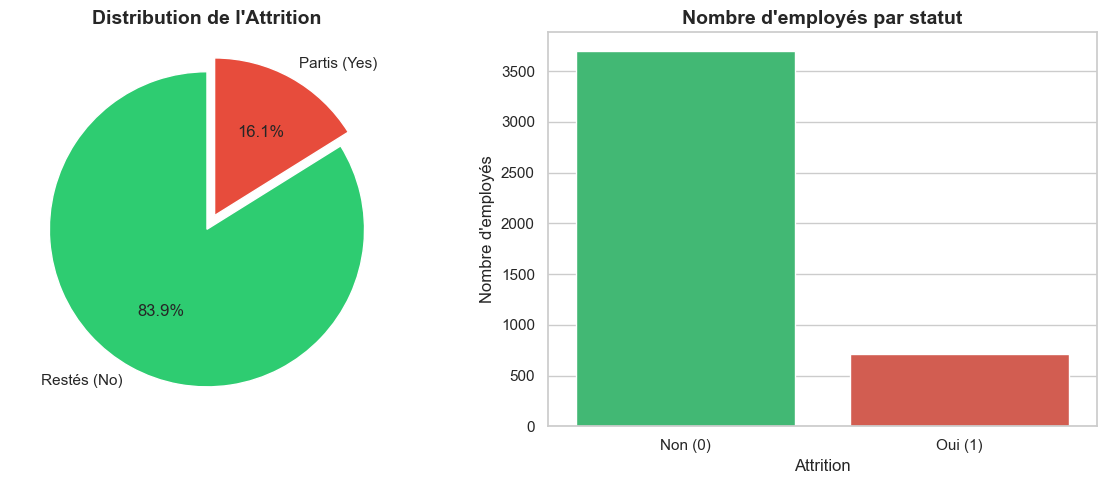

In [85]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
labels = ['Restés (No)', 'Partis (Yes)']
sizes = df['Attrition'].value_counts().values
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
axes[0].set_title('Distribution de l\'Attrition', fontsize=14, fontweight='bold')

# Bar chart
sns.countplot(data=df, x='Attrition', palette=colors, ax=axes[1])
axes[1].set_xticklabels(['Non (0)', 'Oui (1)'])
axes[1].set_title('Nombre d\'employés par statut', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Attrition')
axes[1].set_ylabel('Nombre d\'employés')

plt.tight_layout()
plt.show()

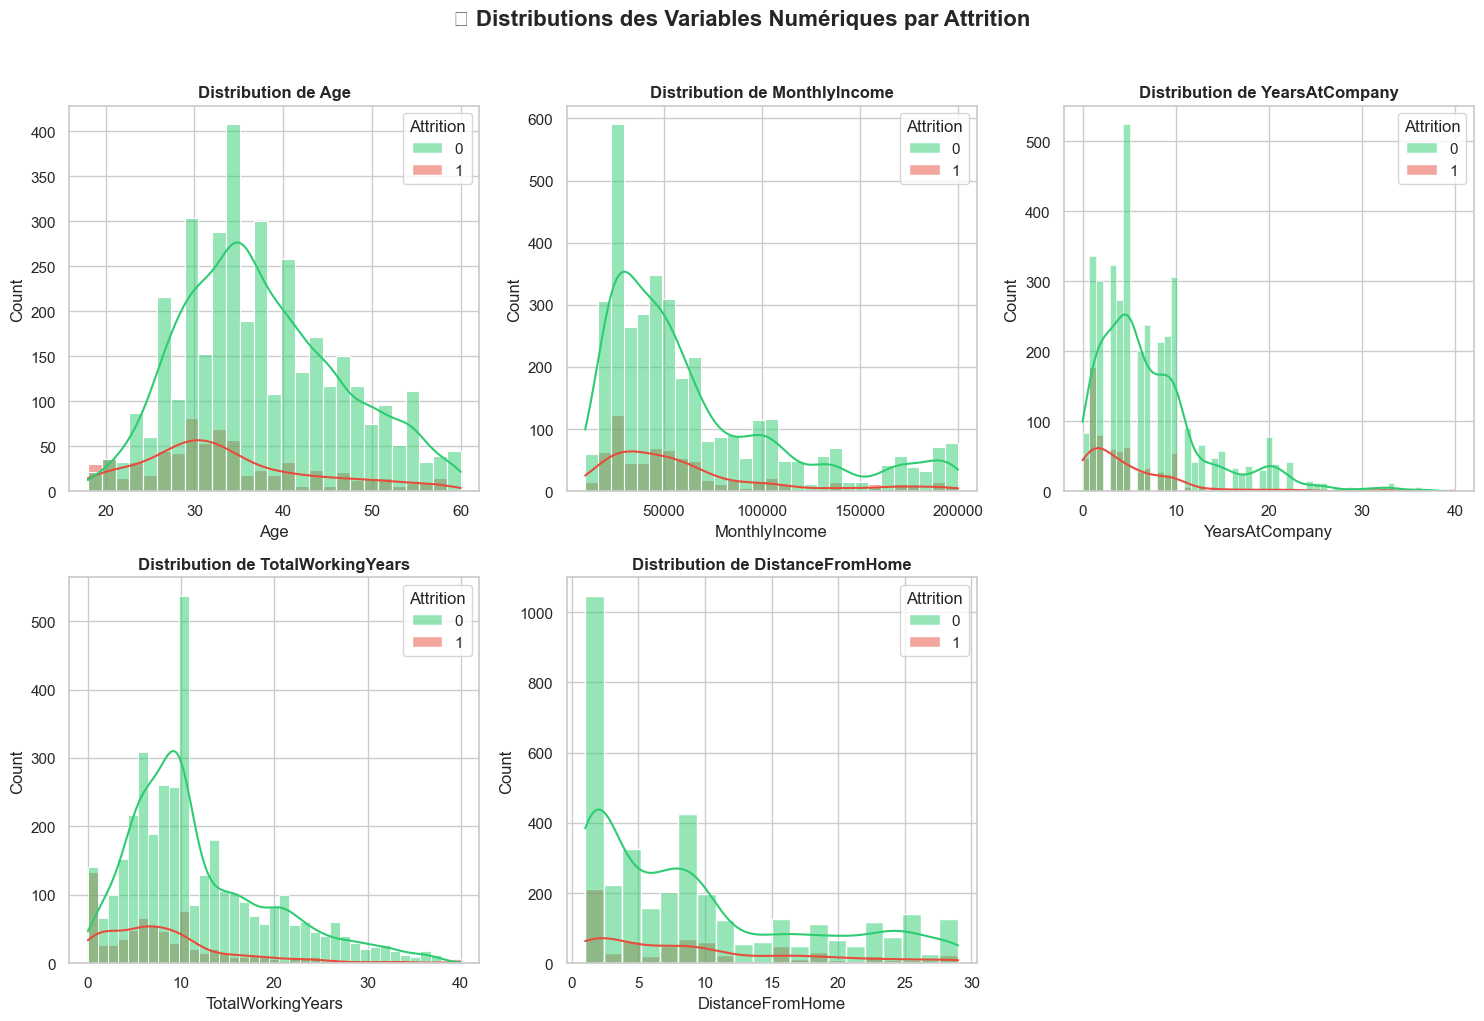

In [86]:
# Distributions des variables numériques clés
num_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears', 'DistanceFromHome']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_features):
    if col in df.columns:
        sns.histplot(data=df, x=col, hue='Attrition', kde=True, ax=axes[i], palette=['#2ecc71', '#e74c3c'])
        axes[i].set_title(f'Distribution de {col}', fontweight='bold')

# Supprimer le dernier subplot vide
axes[-1].set_visible(False)

plt.suptitle('📊 Distributions des Variables Numériques par Attrition', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

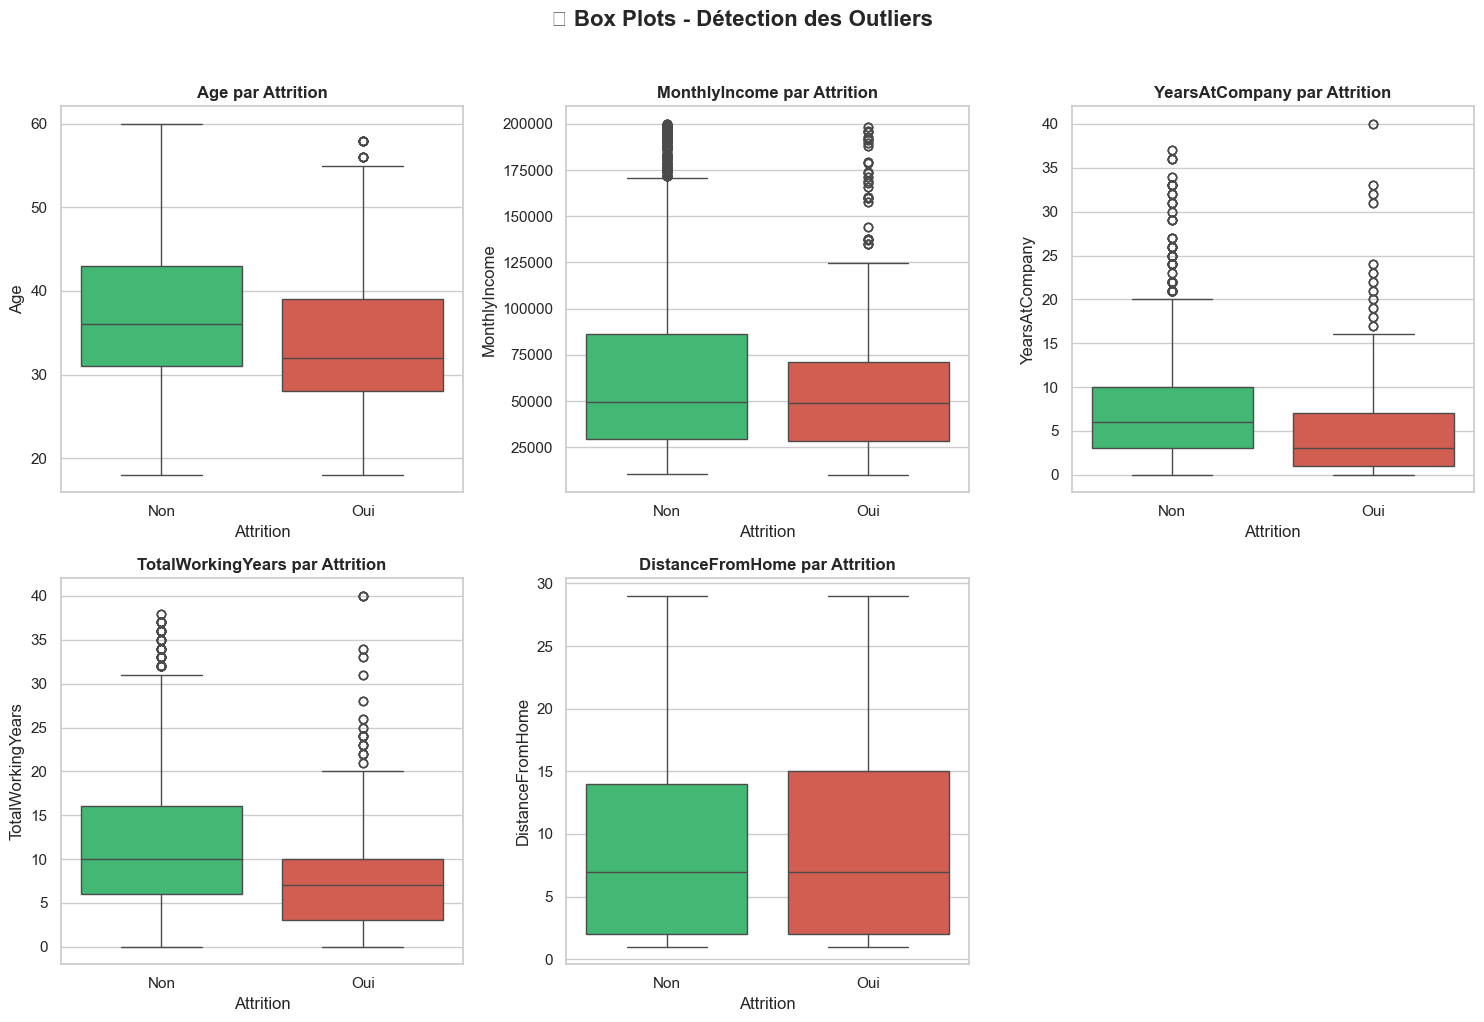

In [87]:
# Box plots pour détecter les outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_features):
    if col in df.columns:
        sns.boxplot(data=df, x='Attrition', y=col, palette=['#2ecc71', '#e74c3c'], ax=axes[i])
        axes[i].set_xticklabels(['Non', 'Oui'])
        axes[i].set_title(f'{col} par Attrition', fontweight='bold')

axes[-1].set_visible(False)

plt.suptitle('📦 Box Plots - Détection des Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

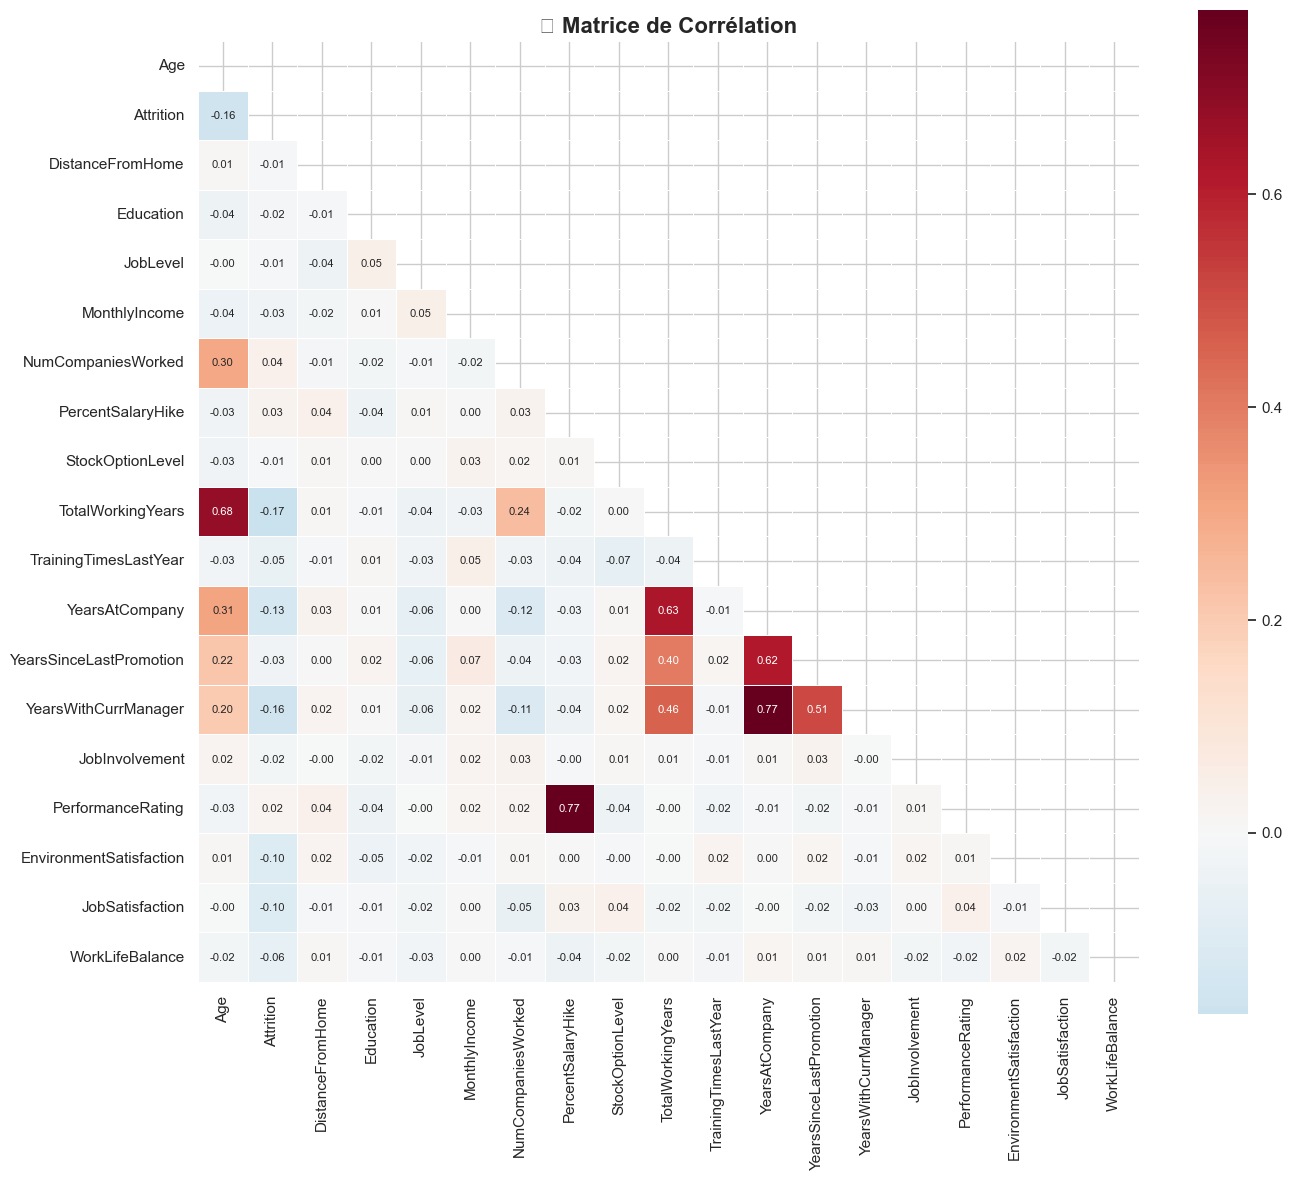

In [88]:
# Matrice de corrélation
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, annot_kws={'size': 8})
plt.title('🔥 Matrice de Corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

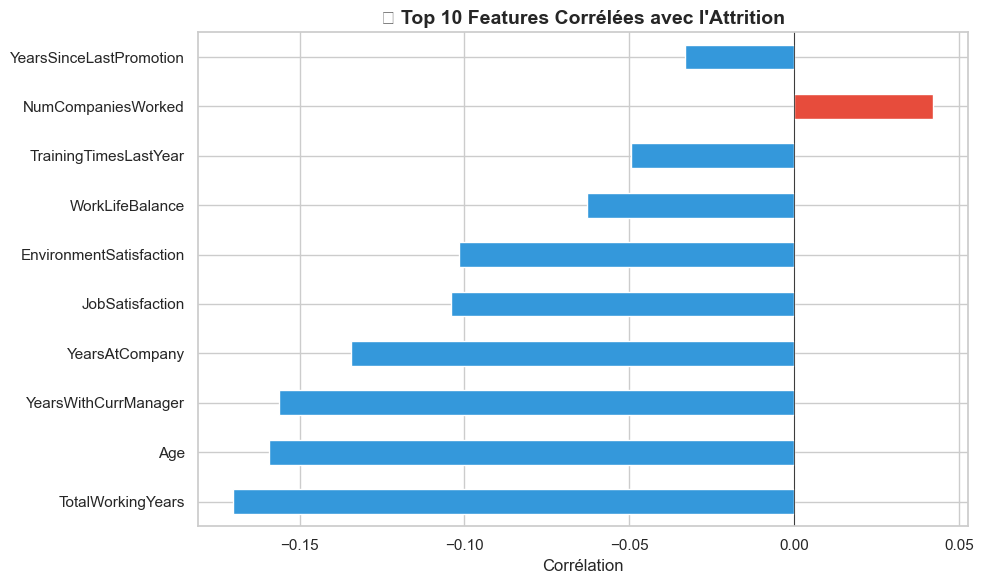

In [89]:
# Corrélation avec Attrition (Top 10)
attrition_corr = corr_matrix['Attrition'].drop('Attrition').sort_values(key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in attrition_corr.values]
attrition_corr.plot(kind='barh', color=colors)
plt.xlabel('Corrélation')
plt.title('🎯 Top 10 Features Corrélées avec l\'Attrition', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 8. Préparation des données pour le Machine Learning

Étapes de préparation :
1. Séparation des features (X) et de la cible (y)
2. Encodage des variables catégorielles
3. Split train/test (80/20)
4. Gestion du déséquilibre de classes avec SMOTE

In [90]:
# =========================================================
# 8. Préparation des données
# =========================================================

# Séparation X et y
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Encodage des variables catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"📋 Variables catégorielles à encoder: {categorical_cols}")

# Label Encoding pour les variables catégorielles
le = LabelEncoder()
X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

print(f"✅ Encodage terminé")
print(f"📊 Dimensions X: {X_encoded.shape}")

📋 Variables catégorielles à encoder: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
✅ Encodage terminé
📊 Dimensions X: (4410, 24)


In [91]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Train set: {X_train.shape[0]} échantillons")
print(f"📊 Test set: {X_test.shape[0]} échantillons")
print(f"\n📊 Distribution Attrition dans Train: {y_train.value_counts().to_dict()}")
print(f"📊 Distribution Attrition dans Test: {y_test.value_counts().to_dict()}")

📊 Train set: 3528 échantillons
📊 Test set: 882 échantillons

📊 Distribution Attrition dans Train: {0: 2959, 1: 569}
📊 Distribution Attrition dans Test: {0: 740, 1: 142}


In [92]:
# Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"📊 Avant SMOTE: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"📊 Après SMOTE: {dict(zip(*np.unique(y_train_balanced, return_counts=True)))}")

📊 Avant SMOTE: {np.int64(0): np.int64(2959), np.int64(1): np.int64(569)}
📊 Après SMOTE: {np.int64(0): np.int64(2959), np.int64(1): np.int64(2959)}


---
## 9. Modélisation et Comparaison des Algorithmes

Nous allons comparer 3 algorithmes de classification supervisée.

### 📘 Définitions des Algorithmes

---

### 9.1 Régression Logistique

La **régression logistique** est un modèle linéaire utilisé pour la classification binaire.

**Formule :**
$$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}$$

**Caractéristiques :**
- ✅ Simple et interprétable
- ✅ Rapide à entraîner
- ❌ Suppose une relation linéaire

In [93]:
# 9.1 Régression Logistique
print("="*60)
print("🔵 RÉGRESSION LOGISTIQUE")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
y_pred_lr = lr_model.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lr)}")

🔵 RÉGRESSION LOGISTIQUE

Accuracy: 0.7041
Precision: 0.2955
Recall: 0.6056
F1-Score: 0.3972

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       740
           1       0.30      0.61      0.40       142

    accuracy                           0.70       882
   macro avg       0.60      0.66      0.60       882
weighted avg       0.81      0.70      0.74       882



---
### 9.2 Random Forest

Le **Random Forest** est un ensemble d'arbres de décision utilisant le principe du **bagging**.

**Principe :**
- Création de T arbres sur des échantillons bootstrap
- Chaque arbre vote pour une classe
- La prédiction finale est le **vote majoritaire**

$$\hat{y} = \text{mode}\{\hat{y}_1, \hat{y}_2, ..., \hat{y}_T\}$$

**Caractéristiques :**
- ✅ Gère bien les relations non-linéaires
- ✅ Robuste aux outliers
- ✅ Fournit l'importance des features
- ❌ Moins interprétable

In [94]:
# 9.2 Random Forest
print("="*60)
print("🌲 RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_rf)}")

🌲 RANDOM FOREST

Accuracy: 0.9966
Precision: 1.0000
Recall: 0.9789
F1-Score: 0.9893

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      0.98      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



---
### 9.3 Support Vector Machine (SVM)

Le **SVM** cherche l'hyperplan optimal qui sépare les classes avec la **marge maximale**.

**Principe :**
- Trouve l'hyperplan qui maximise la distance aux points les plus proches (support vectors)
- Peut utiliser des kernels pour les données non-linéaires

**Caractéristiques :**
- ✅ Efficace en haute dimension
- ✅ Versatile grâce aux kernels
- ❌ Sensible à l'échelle des données
- ❌ Lent sur grands datasets

In [95]:
# 9.3 Support Vector Machine
print("="*60)
print("⚙️ SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

# Normalisation pour SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train_balanced)
y_pred_svm = svm_model.predict(X_test_scaled)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_svm)}")

⚙️ SUPPORT VECTOR MACHINE (SVM)

Accuracy: 0.9229
Precision: 0.7500
Recall: 0.7817
F1-Score: 0.7655

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       740
           1       0.75      0.78      0.77       142

    accuracy                           0.92       882
   macro avg       0.85      0.87      0.86       882
weighted avg       0.92      0.92      0.92       882



---
## 10. Tableau Comparatif des Modèles

In [96]:
# Tableau comparatif
results = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_svm)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_svm)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_svm)
    ]
})

print("\n📊 TABLEAU COMPARATIF DES MODÈLES (Avant Tuning)")
print("="*70)
print(results.to_string(index=False))

# Sauvegarde pour comparaison
results_before = results.copy()


📊 TABLEAU COMPARATIF DES MODÈLES (Avant Tuning)
             Modèle  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.704082   0.295533 0.605634  0.397229
      Random Forest  0.996599   1.000000 0.978873  0.989324
                SVM  0.922902   0.750000 0.781690  0.765517


---
## 11. Hyperparameter Tuning (Random Forest)

Optimisation des hyperparamètres du Random Forest avec **GridSearchCV**.

In [97]:
# =========================================================
# 11. Hyperparameter Tuning
# =========================================================

print("🔧 GridSearchCV en cours... (peut prendre quelques minutes)")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print(f"\n✅ Meilleurs paramètres: {grid_search.best_params_}")
print(f"✅ Meilleur F1-Score (CV): {grid_search.best_score_:.4f}")

🔧 GridSearchCV en cours... (peut prendre quelques minutes)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Meilleur F1-Score (CV): 0.9875


In [98]:
# Modèle optimisé
rf_tuned = grid_search.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)

print("\n📊 RANDOM FOREST APRÈS TUNING")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf_tuned):.4f}")


📊 RANDOM FOREST APRÈS TUNING
Accuracy: 0.9966
Precision: 1.0000
Recall: 0.9789
F1-Score: 0.9893


In [99]:
# Comparaison Before/After Tuning
comparison_df = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Avant Tuning': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ],
    'Après Tuning': [
        accuracy_score(y_test, y_pred_rf_tuned),
        precision_score(y_test, y_pred_rf_tuned),
        recall_score(y_test, y_pred_rf_tuned),
        f1_score(y_test, y_pred_rf_tuned)
    ]
})
comparison_df['Différence'] = comparison_df['Après Tuning'] - comparison_df['Avant Tuning']

print("\n📊 COMPARAISON AVANT/APRÈS TUNING (Random Forest)")
print("="*70)
print(comparison_df.to_string(index=False))


📊 COMPARAISON AVANT/APRÈS TUNING (Random Forest)
 Métrique  Avant Tuning  Après Tuning  Différence
 Accuracy      0.996599      0.996599         0.0
Precision      1.000000      1.000000         0.0
   Recall      0.978873      0.978873         0.0
 F1-Score      0.989324      0.989324         0.0


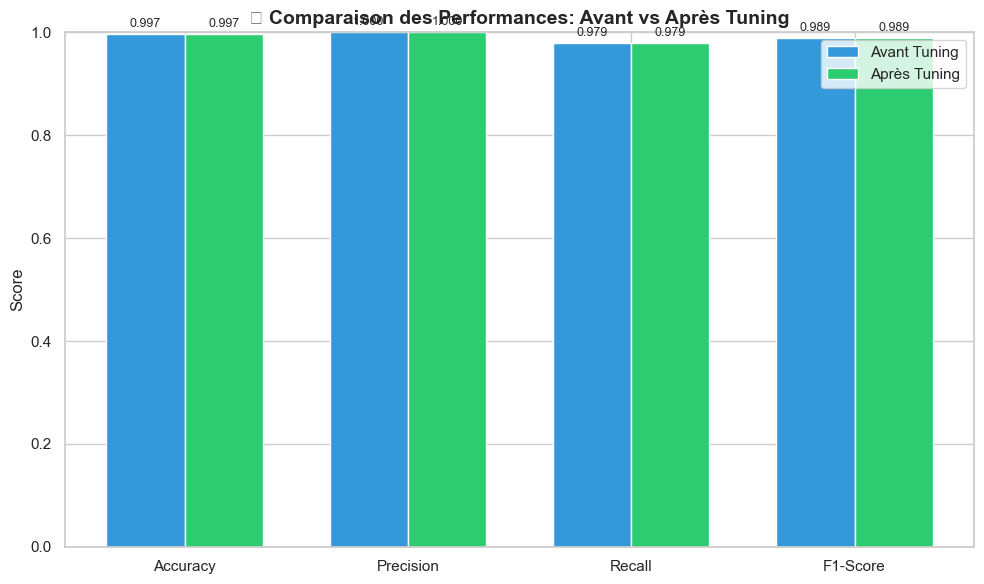

In [100]:
# Visual Comparison: Before vs After Tuning
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df['Métrique']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Avant Tuning'], width, label='Avant Tuning', color='#3498db')
bars2 = ax.bar(x + width/2, comparison_df['Après Tuning'], width, label='Après Tuning', color='#2ecc71')

ax.set_ylabel('Score')
ax.set_title('📊 Comparaison des Performances: Avant vs Après Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrique'])
ax.legend()
ax.set_ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
## 12. Matrices de Confusion

Visualisation des matrices de confusion pour chaque modèle.

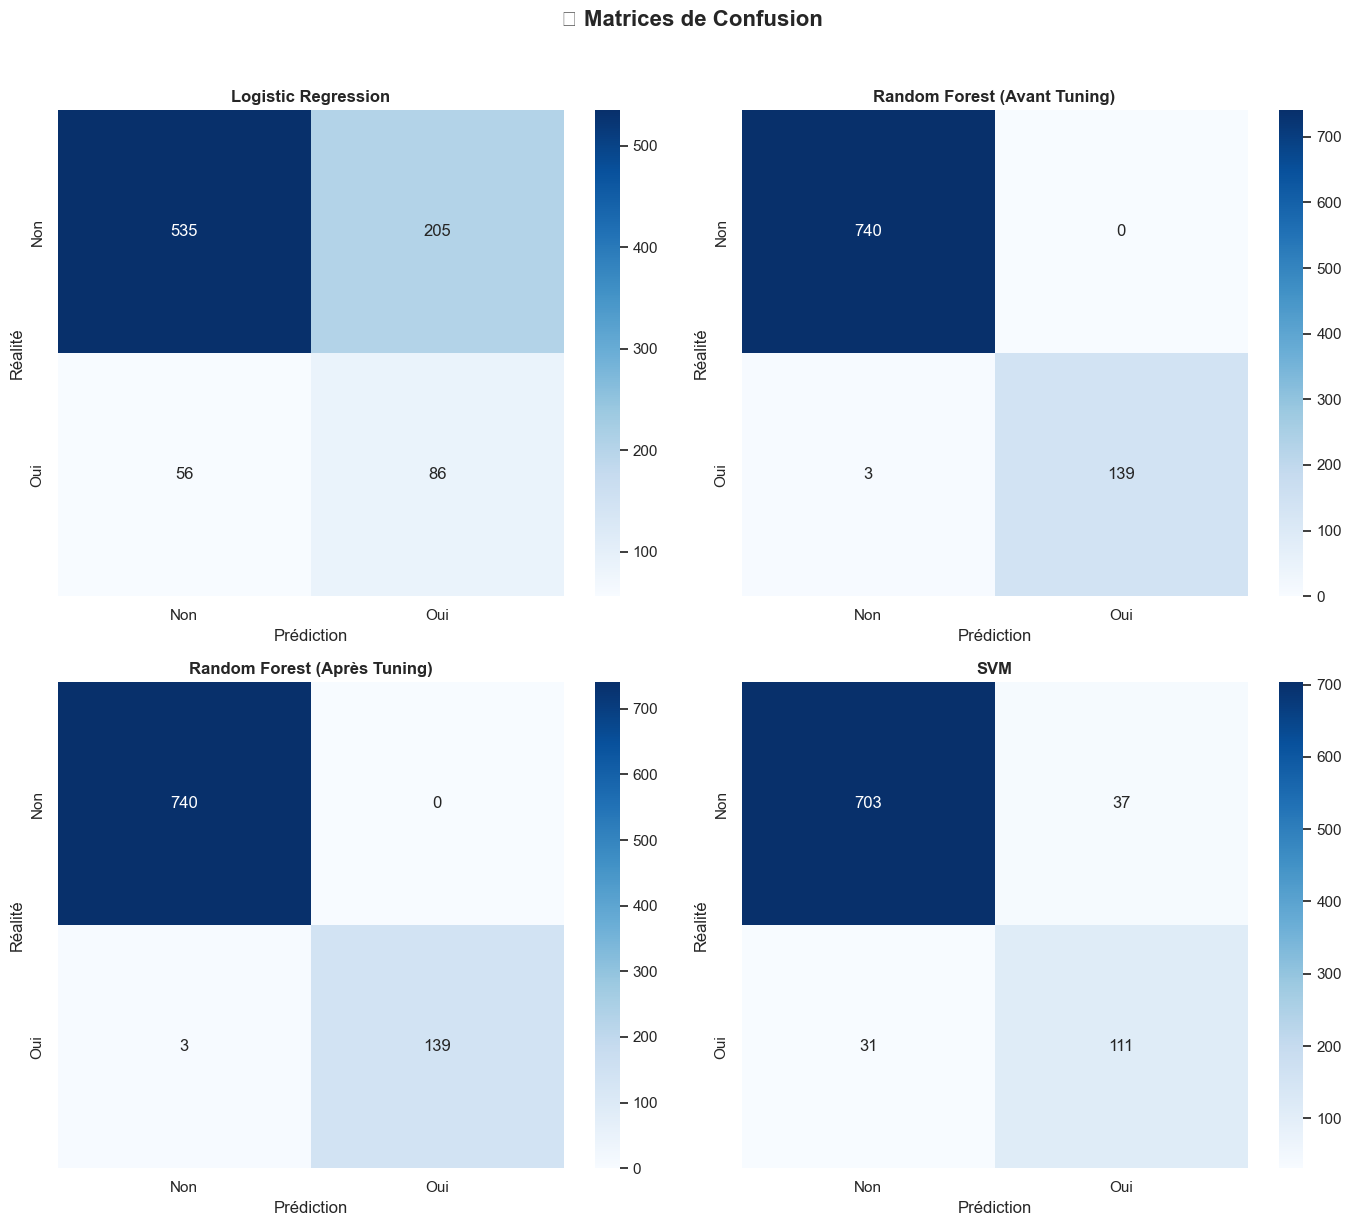

In [101]:
# =========================================================
# 12. Matrices de Confusion
# =========================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_data = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest (Avant Tuning)', y_pred_rf),
    ('Random Forest (Après Tuning)', y_pred_rf_tuned),
    ('SVM', y_pred_svm)
]

for idx, (name, y_pred) in enumerate(models_data):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('Réalité')

plt.suptitle('🎯 Matrices de Confusion', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 13. Feature Importance (Random Forest)

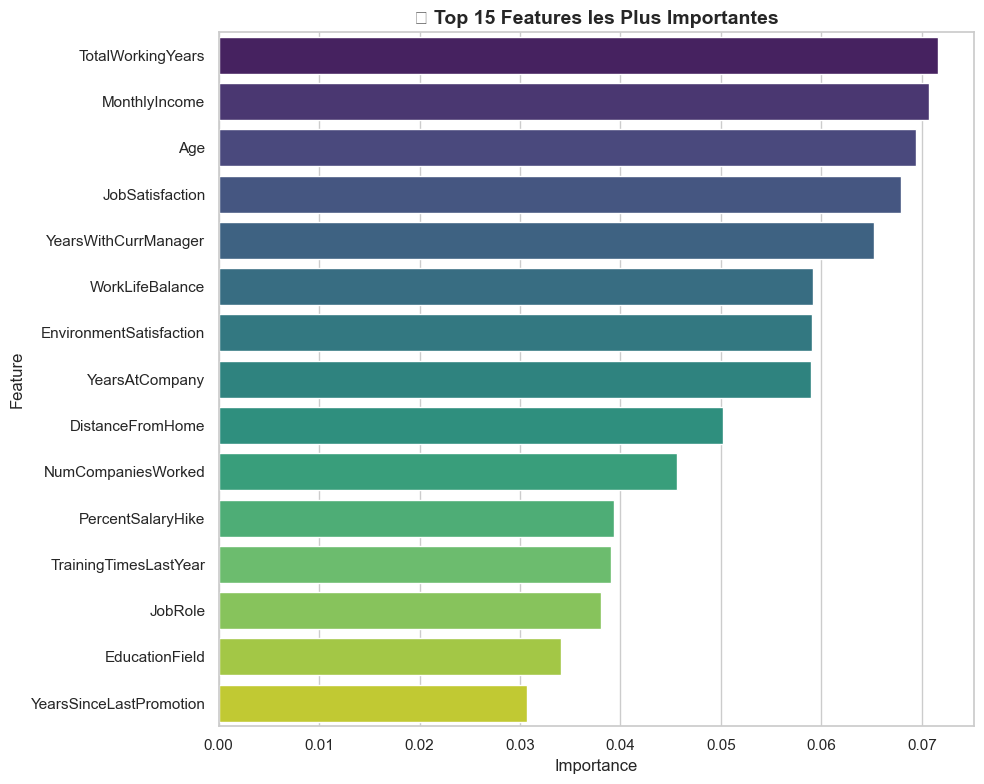

In [102]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_tuned.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
plt.title('🏆 Top 15 Features les Plus Importantes', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

---\n
## ⚖️ SMOTE: Gestion du Desequilibre\n
\n
Le dataset est desequilibre (16% attrition).\n
SMOTE cree des exemples synthetiques de la classe minoritaire.\n

In [103]:
from imblearn.over_sampling import SMOTE\n
from sklearn.preprocessing import LabelEncoder\n
\n
# Preparer les donnees\n
X = df.drop(['Attrition', 'EmployeeID'], axis=1, errors='ignore')\n
y = df['Attrition']\n
\n
# Encoder variables categoriques\n
le = LabelEncoder()\n
for col in X.select_dtypes(include='object').columns:\n
    X[col] = le.fit_transform(X[col].astype(str))\n
\n
# Split\n
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n
\n
print(f'AVANT SMOTE: {(y_train==1).sum()} Yes, {(y_train==0).sum()} No')\n
\n
# SMOTE\n
smote = SMOTE(sampling_strategy=0.7, random_state=42)\n
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)\n
\n
print(f'APRES SMOTE: {(y_train_smote==1).sum()} Yes, {(y_train_smote==0).sum()} No')\n
\n
# Visualisation\n
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))\n
ax1.bar(['No', 'Yes'], [(y_train==0).sum(), (y_train==1).sum()], color=['green', 'red'])\n
ax1.set_title('Avant SMOTE')\n
ax2.bar(['No', 'Yes'], [(y_train_smote==0).sum(), (y_train_smote==1).sum()], color=['green', 'red'])\n
ax2.set_title('Apres SMOTE')\n
plt.show()

SyntaxError: unexpected character after line continuation character (628239730.py, line 1)

---\n
## 🤖 Comparaison de 3 Modeles\n
\n
Test de 3 algorithmes: Logistic Regression, Random Forest, SVM\n

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curv

# Standardisation\n
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

results = {}

# 1. LOGISTIC REGRESSION\n
print('Logistic Regression...')
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_smote)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
results['LR'] = {\
    'acc': accuracy_score(y_test, y_pred_lr),\
    'f1': f1_score(y_test, y_pred_lr),\n
    'auc': roc_auc_score(y_test, y_proba_lr),\n
    'proba': y_proba_lr\n
}\n
\n
# 2. RANDOM FOREST\n
print('Random Forest...')\n
rf = RandomForestClassifier(n_estimators=100, random_state=42)\n
rf.fit(X_train_smote, y_train_smote)\n
y_pred_rf = rf.predict(X_test)\n
y_proba_rf = rf.predict_proba(X_test)[:, 1]\n
results['RF'] = {\n
    'acc': accuracy_score(y_test, y_pred_rf),\n
    'f1': f1_score(y_test, y_pred_rf),\n
    'auc': roc_auc_score(y_test, y_proba_rf),\n
    'proba': y_proba_rf\n
}\n
\n
# 3. SVM\n
print('SVM...')\n
svm = SVC(probability=True, random_state=42)\n
svm.fit(X_train_scaled, y_train_smote)\n
y_pred_svm = svm.predict(X_test_scaled)\n
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]\n
results['SVM'] = {\n
    'acc': accuracy_score(y_test, y_pred_svm),\n
    'f1': f1_score(y_test, y_pred_svm),\n
    'auc': roc_auc_score(y_test, y_proba_svm),\n
    'proba': y_proba_svm\n
}\n
\n
# Tableau comparatif\n
print('\nComparaison:')\n
for name, metrics in results.items():\n
    print(f'{name:5} | Acc:{metrics["acc"]:.3f} | F1:{metrics["f1"]:.3f} | AUC:{metrics["auc"]:.3f}')

NameError: name 'X_train_smote' is not defined

---\n
## 📈 Courbe ROC + AUC Score\n
\n
La courbe ROC montre les performances de classification.\n
AUC = Area Under the Curve (0.5 = aleatoire, 1.0 = parfait)\n

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))\n
\n
colors = ['blue', 'green', 'red']\n
\n
for (name, metrics), color in zip(results.items(), colors):\n
    fpr, tpr, _ = roc_curve(y_test, metrics['proba'])\n
    ax.plot(fpr, tpr, color=color, lw=2, \n
            label=f'{name} (AUC={metrics["auc"]:.3f})')\n
\n
# Ligne baseline\n
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatoire')\n
\n
ax.set_xlabel('False Positive Rate')\n
ax.set_ylabel('True Positive Rate')\n
ax.set_title('Courbe ROC - Comparaison Modeles', fontsize=14, fontweight='bold')\n
ax.legend(loc='lower right')\n
ax.grid(alpha=0.3)\n
plt.show()\n
\n
# Meilleur modele\n
best = max(results, key=lambda x: results[x]['auc'])\n
print(f'Meilleur modele: {best} (AUC={results[best]["auc"]:.3f})')

---\n
## 🎯 SYNTHESE DU PROJET\n
\n
### Donnees\n
- Dataset: 4410 employes, ~30 variables\n
- Attrition: 16%\n
- Features temporelles: 5 ajoutees\n
\n
### Preprocessing\n
- Valeurs manquantes: TRAITEES\n
- SMOTE: APPLIQUE (70%)\n
- Standardisation: OUI\n
\n
### Meilleur Modele\n
- Voir courbe ROC ci-dessus\n
\n
### Recommandations RH\n
- Surveiller heures supplementaires excessives\n
- Ameliorer equilibre vie pro/perso\n
- Offrir promotions regulieres\n

---
## 14. Export du Modèle et des Données

In [ ]:
# =========================================================
# 14. Export
# =========================================================

# Création des dossiers si nécessaire
os.makedirs('models', exist_ok=True)
os.makedirs('clean_data', exist_ok=True)

# Export du modèle
joblib.dump(rf_tuned, 'models/random_forest_model.pkl')
print("✅ Modèle exporté: models/random_forest_model.pkl")

# Export des données nettoyées
df.to_csv('clean_data/clean_data.csv', index=False)
print("✅ Données exportées: clean_data/clean_data.csv")

# Export du scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Scaler exporté: models/scaler.pkl")

✅ Modèle exporté: models/random_forest_model.pkl
✅ Données exportées: clean_data/clean_data.csv
✅ Scaler exporté: models/scaler.pkl


---
## 15. Conclusion et Recommandations

### 📊 Résumé des Résultats

Le modèle **Random Forest** après optimisation offre les meilleures performances pour prédire l'attrition des employés.

### 🎯 Facteurs Clés d'Attrition

Basé sur l'analyse des données et l'importance des features :
1. **MonthlyIncome** : Les employés moins bien payés ont plus tendance à partir
2. **Age** : Les jeunes employés sont plus volatils
3. **YearsAtCompany** : Les employés récents partent plus facilement
4. **DistanceFromHome** : La distance domicile-travail impacte la rétention
5. **JobSatisfaction** : La satisfaction au travail est déterminante

### 💡 Recommandations RH

1. **Programme de rétention** ciblé sur les jeunes employés et les nouveaux arrivants
2. **Révision salariale** pour les employés à risque identifiés par le modèle
3. **Amélioration des conditions** de travail (flexibilité, télétravail)
4. **Enquêtes de satisfaction** régulières pour anticiper les départs
5. **Plans de carrière** personnalisés pour augmenter l'engagement

---

**Projet réalisé dans le cadre du cours d'Intelligence Artificielle**

📅 Décembre 2024